<a href="https://colab.research.google.com/github/UlviDemirsoy/finetuning-embeddings-word2vec/blob/main/NeuralNetworkProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#abdüllatif köksalın embeddingleri
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.optim as optim
import torch.nn as nn
from IPython import display


from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/trmodel', binary=True)
type(word_vectors)


gensim.models.keyedvectors.KeyedVectors

In [4]:
len(word_vectors)

412457

In [5]:
indexedwords=word_vectors.index_to_key
#print(words)

vectors_array = np.zeros((len(word_vectors), word_vectors.vector_size))
for i, word in enumerate(word_vectors.index_to_key):
   # print(word, word_vectors[word])
    vectors_array[i] = word_vectors[word]

# Now vectors_array contains the vectors for each word
print(len(vectors_array))



412457


In [6]:
#AutoEncoder

In [7]:
print(type(vectors_array))
vectors_array.shape

<class 'numpy.ndarray'>


(412457, 400)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


x_train_tensor = torch.from_numpy(vectors_array).float()
y_train_tensor = torch.from_numpy(vectors_array).float()

learning_rate = 1e-2 # alpha


class AE(nn.Module):
    def __init__(self, n_features, n_hidden):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_features)

    def encode(self, x):
        return self.fc1(x)

    def decode(self, x):
        return self.fc2(x)

    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)


ae = AE(400, 40)


criterion = nn.MSELoss() # (x-y)^2
optimizer = torch.optim.Adam(ae.parameters(),
                             lr=learning_rate)
n_epoch = 200
losses = []
for t in range(n_epoch):

    # Feed forward to get the logits
    # y_pred = model_compress(x_train_tensor)
    y_pred = ae(x_train_tensor)

    # Compute the loss
    loss = criterion(y_pred, y_train_tensor)
    # Dont accumulate previous gradients
    optimizer.zero_grad()

    print(f"[EPOCH]: {t}/{n_epoch}, [LOSS]: {loss.item():.6f}")
    display.clear_output(wait=True)
    losses.append(loss.item())

    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params.
    loss.backward()

    # Update params with some gradient-based method
    optimizer.step()

[EPOCH]: 199/200, [LOSS]: 0.019508


In [9]:
print(device)

cuda


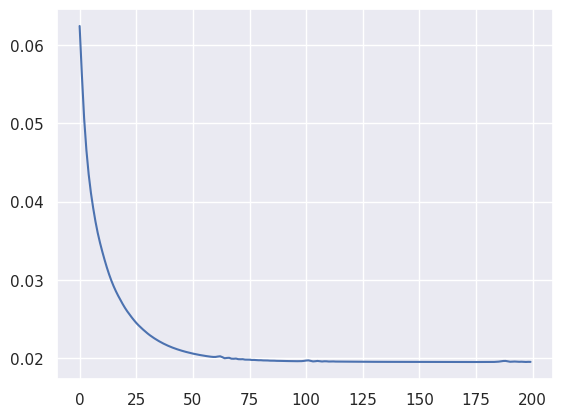

In [10]:
plt.plot(losses)

In [11]:
torch.save(ae, '/content/drive/MyDrive/autoencodermodel.pt')

In [12]:
model = torch.load('/content/drive/MyDrive/autoencodermodel.pt')

In [13]:
model.parameters()

<generator object Module.parameters at 0x7e06706ac660>

In [14]:
#get encoded low dimension embeddings
lowerdimensionembeddings = ae.encode(x_train_tensor)
print(lowerdimensionembeddings.shape)



# print(word_vectors.similarity('galatasaray','spor'))
# result = word_vectors.similar_by_word("futbol")
# print(result)

torch.Size([412457, 40])


In [15]:
print(device)

cuda


In [16]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("mertbozkurt/llama2-TR-recipe")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

regular_punct = list(string.punctuation)

def remove_punctuation(text,punct_list):
  for punc in punct_list:
      if punc in text:
          text = text.replace(punc, ' ')
  return text.strip()

ps = PorterStemmer()
stopWords = set(stopwords.words('turkish'))
wordsFiltered = []
numerics_removed_words = []
embedding_test = []
counter = 0
for text_dict in dataset["train"]:
  text = text_dict["text"]
  clean_text = remove_punctuation(text, regular_punct)
  words = word_tokenize(clean_text.lower())
  for w in words:
      if w in stopWords:
          continue
      elif not w.isnumeric():
        numerics_removed_words.append(w)
        if counter < 100:
          embedding_test.append(w)
        counter += 1

In [19]:
#yeni gelen kelimeleri bulup random vector initialize edilir

setindextedword = set(indexedwords)
new_words = set(numerics_removed_words)
difference = list(new_words.difference(setindextedword))
print(difference)
print(len(difference))

['közlemeye', 'yoğurt2', 'sarımsaktuzkarabiber', 'fasulyelerini', 'turşularının', '40dk', 'kuruyacak', 'pirinçlerin', 'dilimlenmesi', 'sarmasının', 'büyültebilirsiniz', 'kebabımeksika', 'tozu1', 'kolaylaştırmakla', 'sirkeler', 'bastırmayın', 'su3', 'birleşmiyorsa', 'yürümeniz', 'kabardığında', 'salatalarınızın', 'batırabileceğiniz', 'petibör', 'eklemeyebilirsiniz', 'oklavanın', 'enerjinizin', 'su4', 'kızartabilirsiniz', 'lahanalarınızın', 'vişne4', 'muhallebili', 'çitlembikleri', 'nişaşta', '250gr', 'lokumunu', 'yoğurabilirsiniz', 'lezzetlisi', 'kızartmasına', 'bulamak', 'salçası4', 'karalahanaları', 'oklavaya', 'hamsiyi', 'çağlalar', 'zerdeçallı', 'kürüya', 'sönmesini', 'kaşığıgaleta', 'lolorossoyu', 'irmikyaklaşık', 'şantili', 'kullanabilirsiniz', 'pancarlar', 'bulayın', 'inst', 'reçelini', 'pastırmayı', 'pastadamla', 'izgara', 'kabarsın', 'peyniri1', 'bohçalarını', 'kılçığını', 'harcınızı', 'etlerle', 'banmalık', 'gözükecekleri', 'yayarsanız', 'pişsin', 'bakliyatları', 'madımakları'

In [20]:
randomembeddings = np.random.rand(len(difference), 40)

copystore = np.copy(lowerdimensionembeddings.detach().numpy())
for w in difference:
  indexedwords.append(w)

 # lowerdimensionembeddings = np.concatenate((lowerdimensionembeddings, np.random.rand(40)), axis=0)
copystore = np.vstack([copystore, randomembeddings])#en doğru initialization yöntemi

In [21]:
print(len(indexedwords), len(copystore))

417057 417057


In [22]:
#fine tune embeddings with new dataset

import pandas as pd

id2tok = dict(enumerate(indexedwords))
tok2id = {token: id for id, token in id2tok.items()}

print(type(tok2id))
#print(tok2id)


data = {'input1': [], 'input2': [], 'output': []}

reverse_data = {'input1': [], 'input2': [], 'output': []}
numerics_removed_words

for i in range(len(numerics_removed_words)-1):
  data['input1'].append(numerics_removed_words[i])
  data['input2'].append(numerics_removed_words[i+1])
  data['output'].append(1)


for i in range(len(numerics_removed_words)-1,1,-1):
  reverse_data['input1'].append(numerics_removed_words[i])
  reverse_data['input2'].append(numerics_removed_words[i-1])
  reverse_data['output'].append(1)

#print("validen",data[:,:-1])
df_data = pd.DataFrame(data)
#df_data
df_reverse = pd.DataFrame(reverse_data)
#df_reverse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

print("tok2idget",tok2id.get)
class data_set(Dataset):
  def __init__(self, data):
    self.X = np.vectorize(tok2id.get)(data[:,:-1])
    self.y = data[:,-1]
  def __len__(self):
    return len(self.X)
  def getx(self):
    return self.X
  def __getitem__(self, index):
    return self.X[index], self.y[index]


dataset = data_set(pd.concat([df_data, df_reverse], ignore_index=True).values)


evens = list(range(0, len(dataset), 2))
trainset = torch.utils.data.Subset(dataset, evens)


<class 'dict'>
tok2idget <built-in method get of dict object at 0x7e05e6440b40>


In [23]:
class Word2Vec2(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(copystore))
    self.embedding.requires_grad = True

  def forward(self, X_batch):
    U = self.embedding(X_batch[:,0])
    V = self.embedding(X_batch[:,1])

    output = torch.sigmoid(torch.sum(torch.mul(U, V), 1))
    return output



In [24]:
len(torch.FloatTensor(copystore))

417057

In [25]:
dataloader = DataLoader(trainset, batch_size=len(trainset)//4, shuffle=True)

for i, (batch_X, batch_y) in enumerate(dataloader):
  print(i, batch_X[:,0],batch_X[:,1], batch_y)
  if i >= 2:
    break

0 tensor([  2566,   8092, 118962,  ...,  15869,  26542, 412511]) tensor([  1720,    620,      2,  ...,   5104, 412511,  51218]) tensor([1, 1, 1,  ..., 1, 1, 1])
1 tensor([   243, 412511,   1429,  ...,    172,    118,     52]) tensor([  2788, 413761,   7282,  ...,    620,  58678,   6071]) tensor([1, 1, 1,  ..., 1, 1, 1])
2 tensor([  620,  1204,   847,  ...,  3270,  1632, 28508]) tensor([413758, 416804,   2841,  ...,     16,  29071,    243]) tensor([1, 1, 1,  ..., 1, 1, 1])


In [26]:
type(torch.FloatTensor(vectors_array))

torch.Tensor

In [27]:
from itertools import chain
from collections import Counter

dim_size = 40
embed_size = 5

model = Word2Vec2()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 1e-1
EPOCHS = 200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

from tqdm import tqdm # For progress bars
from IPython import display

running_loss = []
for epoch in tqdm(range(EPOCHS)):
  epoch_loss = 0
  for i, (batch_X, batch_y) in enumerate(dataloader):
    optimizer.zero_grad()
    # X_batch is (i,j) index must be int
    X_batch = batch_X.type(torch.int).to(device)
    # y_batch must be float
    y_batch = batch_y.type(torch.float32).to(device)
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    epoch_loss += loss.item()
    loss.requires_grad = True
    loss.backward()
    optimizer.step()
  epoch_loss /= len(dataloader)
  running_loss.append(epoch_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')
  display.clear_output(wait=True)

100%|██████████| 200/200 [41:38<00:00, 12.49s/it]


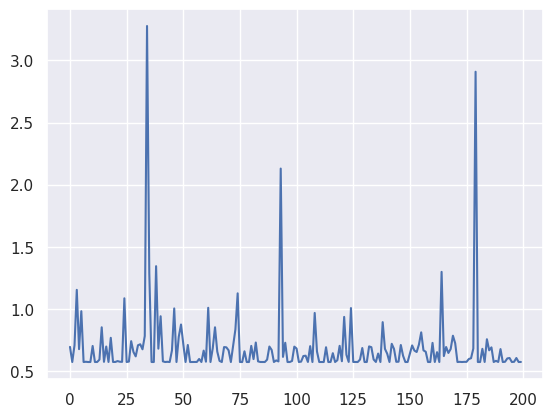

In [28]:
plt.plot(running_loss)

In [29]:
torch.save(model, '/content/drive/MyDrive/word2vecmodel.pt')

In [30]:
test_embeddings = [
    ['biber', 'dolması'],
    ['dana', 'kıyma'],
    ['trakya', 'kapama'],
    ['fırında', 'kuzu'],
    ['nohut', 'yemeği'],
    ['soslu', 'tavuk'],
    ['toz', 'şeker'],
    ['cevizli', 'kek'],
    ['tuz', 'kimyon'],
    ['tuz', 'karabiber'],
    ['tas', 'kebabı'],
]

In [31]:

from IPython.display import display, HTML

df = pd.DataFrame({'words': "", 'old embedding': [], 'new embedding': []})
"""
for words in test_embeddings:
  testembedding = None
  testembedding2 = None
  testembedding = model.embedding(torch.tensor((tok2id.get(f"{words[0]}")), device="cpu"))
  testembedding2 = model.embedding(torch.tensor((tok2id.get(f"{word[1]}")), device="cpu"))
  cosi = torch.nn.CosineSimilarity(dim=0)
  output = cosi(testembedding, testembedding2)
  print("Cosine Similarity of new embeddings",output )

  oldembedding = None
  oldembedding = (torch.tensor(word_vectors[f"{words[0]}"], device="cpu"))
  oldembedding2 = (torch.tensor(word_vectors[f"{words[1]}"], device="cpu"))
  output2 = cosi(oldembedding, oldembedding2)
  print("Cosine Similarity of Köksal's embeddings",output2 )

  df.loc[len(df.index)] =  {'words': f"{words[0]} {words[1]}" ,'old embedding': output2, 'new embedding': output}
"""
display(df)


,words,old embedding,new embedding


In [105]:
word1 = 'biber'
word2 = 'dolması'

testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}



<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7557, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6452, device='cuda:0')


In [37]:
word1 = 'dana'
word2 = 'kıyma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5348, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3915, device='cuda:0')


In [38]:
word1 = 'trakya'
word2 = 'kapama'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.1268, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1048, device='cuda:0')


In [39]:
word1 = 'fırında'
word2 = 'kuzu'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6070, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5269, device='cuda:0')


In [40]:
word1 = 'nohut'
word2 = 'yemeği'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5582, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4660, device='cuda:0')


In [41]:
word1 = 'soslu'
word2 = 'tavuk'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8395, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7602, device='cuda:0')


In [42]:
word1 = 'toz'
word2 = 'şeker'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4591, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4285, device='cuda:0')


In [43]:
word1 = 'cevizli'
word2 = 'kek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6379, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6151, device='cuda:0')


In [44]:
word1 = 'tuz'
word2 = 'kimyon'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6812, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5691, device='cuda:0')


In [45]:
word1 = 'tuz'
word2 = 'karabiber'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7197, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6087, device='cuda:0')


In [46]:
word1 = 'taze'
word2 = 'soğan'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8534, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7526, device='cuda:0')


In [47]:
word1 = 'irmik'
word2 = 'helvası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8968, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8359, device='cuda:0')


In [48]:
word1 = 'sıvı'
word2 = 'yağ'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7766, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6630, device='cuda:0')


In [49]:
word1 = 'bitter'
word2 = 'çikolata'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.3070, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3734, device='cuda:0')


In [50]:
word1 = 'bulgur'
word2 = 'çorbası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8919, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8545, device='cuda:0')


In [51]:
word1 = 'domates'
word2 = 'çorbası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7836, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6739, device='cuda:0')


In [52]:
word1 = 'kırmızı'
word2 = 'lahana'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.2383, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2129, device='cuda:0')


In [53]:
word1 = 'bulgur'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9124, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8554, device='cuda:0')


In [54]:
word1 = 'süzme'
word2 = 'yoğurt'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8469, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7943, device='cuda:0')


In [55]:
word1 = 'ton'
word2 = 'balık'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4353, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2968, device='cuda:0')


In [56]:
word1 = 'kuskus'
word2 = 'salata'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8636, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7725, device='cuda:0')


In [57]:
word1 = 'deniz'
word2 = 'börülce'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.1742, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0669, device='cuda:0')


In [58]:
word1 = 'ramazan'
word2 = 'pide'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4140, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3455, device='cuda:0')


In [59]:
word1 = 'ekmek'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7272, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6309, device='cuda:0')


In [60]:
word1 = 'patates'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8499, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7516, device='cuda:0')


In [61]:
word1 = 'peynirli'
word2 = 'acuka'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5956, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4063, device='cuda:0')


In [62]:
word1 = 'yufka'
word2 = 'börek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9087, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8551, device='cuda:0')


In [63]:
word1 = 'çöp'
word2 = 'şiş'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5712, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4036, device='cuda:0')


In [64]:
word1 = 'tencere'
word2 = 'kapağı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.3016, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2666, device='cuda:0')


In [65]:
word1 = 'izmir'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.2316, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1399, device='cuda:0')


In [66]:
word1 = 'taze'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8236, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6825, device='cuda:0')


In [67]:
word1 = 'kapuska'
word2 = 'yemek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6233, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4026, device='cuda:0')


In [68]:
word1 = 'brüksel'
word2 = 'lahana'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.0405, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0116, device='cuda:0')


In [69]:
word1 = 'kabaklı'
word2 = 'mücver'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6029, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4801, device='cuda:0')


In [70]:
word1 = 'ıspanak'
word2 = 'yemek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6215, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4381, device='cuda:0')


In [71]:
word1 = 'galeta'
word2 = 'un'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(-0.0642, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0123, device='cuda:0')


In [72]:
word1 = 'elma'
word2 = 'dilim'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5337, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4229, device='cuda:0')


In [73]:
word1 = 'patlıcan'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9197, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8369, device='cuda:0')


In [74]:
word1 = 'kabak'
word2 = 'musakka'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8811, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7489, device='cuda:0')


In [75]:
word1 = 'sebze'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6726, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5474, device='cuda:0')


In [76]:
word1 = 'sıcak'
word2 = 'su'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5473, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3224, device='cuda:0')


In [77]:
word1 = 'kuru'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7733, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6249, device='cuda:0')


In [78]:
word1 = 'kızgın'
word2 = 'yağ'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4047, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2554, device='cuda:0')


In [79]:
word1 = 'biber'
word2 = 'dolma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8229, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6685, device='cuda:0')


In [80]:
word1 = 'şark'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.3248, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2091, device='cuda:0')


In [81]:
word1 = 'patates'
word2 = 'püre'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6822, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5783, device='cuda:0')


In [82]:
word1 = 'taze'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8236, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6825, device='cuda:0')


In [83]:
word1 = 'çerkez'
word2 = 'çorba'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5133, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3096, device='cuda:0')


In [84]:
word1 = 'bardakta'
word2 = 'tiramisu'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4114, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2655, device='cuda:0')


In [85]:
word1 = 'kağıt'
word2 = 'kebabı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4605, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4056, device='cuda:0')


In [86]:
word1 = 'etli'
word2 = 'patlıcan'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9065, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8285, device='cuda:0')


In [87]:
word1 = 'isveç'
word2 = 'köftesi'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(-0.0313, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0545, device='cuda:0')


In [88]:
word1 = 'çiğ'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7498, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6607, device='cuda:0')


In [89]:
word1 = 'diş'
word2 = 'sarımsak'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.3781, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3861, device='cuda:0')


In [90]:
word1 = 'bal'
word2 = 'kabağı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6844, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5757, device='cuda:0')


In [91]:
word1 = 'kuru'
word2 = 'üzüm'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6611, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5373, device='cuda:0')


In [92]:
word1 = 'mısır'
word2 = 'un'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.2523, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1330, device='cuda:0')


In [95]:
word1 = 'ayva'
word2 = 'tatlı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7224, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4768, device='cuda:0')


In [96]:
word1 = 'vanilya'
word2 = 'süt'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6675, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5301, device='cuda:0')


In [97]:
word1 = 'ıslak'
word2 = 'kek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4538, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3756, device='cuda:0')


In [98]:
word1 = 'kuru'
word2 = 'baklava'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6271, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5204, device='cuda:0')


In [99]:
word1 = 'tahin'
word2 = 'pekmez'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8459, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7965, device='cuda:0')


In [100]:
word1 = 'ekmek'
word2 = 'kadayıfı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7446, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6094, device='cuda:0')


In [101]:
word1 = 'çilekli'
word2 = 'parfe'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7516, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6477, device='cuda:0')


In [102]:
word1 = 'antep'
word2 = 'fıstıklı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7852, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5843, device='cuda:0')


In [103]:
#print(df.to_markdown())
